# Анализ оттока клиентов

## МАТЕРИАЛЫ
Презентация: (https://disk.yandex.ru/i/kHOtk3-o5MJf7A)

Датасет содержит данные о клиентах банка, расположенного в нескольких городах России.

**Целью работы является** выявление ключевых сегментов клиентов с высоким риском ухода и разработка рекомендаций, способствующих росту лояльности клиентов и увеличению выручки банка.

**Задачи:**

1) **Загрузить данные и подготовить их к анализу:**
   - привести название столбцов к нижнему регистру
   - привести данные к нужному типу
   - обработать пропуски (классифицировать пропуски и заменить пропущенные значения/ удалить строки с пропусками/ оставить как есть)
   - обработать дубликаты (проверить наличие явных и неявных дубликатов по user_id)
   - осуществить кодирование признаков (для использования в анализе корреляции)

2) **Произвести исследовательский анализ данных:**
   - проанализировать признаки в разрезе оттока (для непрерывных признаков определить отточные интервалы, а для категориальных/дискретных - значения признака с оттоком выше, чем по банку)
   - составить портреты клиентов, склонных и не склонных к уходу
   - осуществить корреляционный анализ признака churn с другими признаками

3) **Проверить статистические гипотезы:**
   - доход между теми клиентами, которые ушли и теми, которые остались, различается
   - вторая гипотеза будет определена в ходе исследования

4) **Выделить признаки, влияющие на отток:**
   - подвести промежуточные итоги по исследовательскому и корреляционному анализу, проверке гипотез и выделить признаки, влияющие на отток

5) **Осуществить сегментацию клиентов:**
   - выделить не менее трёх сегментов клиентов (от 500 человек) с долей оттока выше средней по банку
   - осуществить приоритизацию сегментов для эффективного формирования рассылок

6) **Сформировать рекомендации для каждого сегмента** 

## 1) Загрузим данные и подготовим их к анализу

In [1]:
!pip install phik

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy import stats as st 
from scipy.stats import pearsonr, spearmanr
import math
import phik                  
from phik import phik_matrix 
import itertools

In [3]:
df = pd.read_csv(r"C:\Users\tsyko\Downloads\bank_scrooge.csv", sep=',')

In [4]:
df.head() # посмотрим на датасет

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


Приведём названия столбцов к нижнему регистру для удобства

In [5]:
df.columns = df.columns.str.lower()
df.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [7]:
df.isna().mean()*100 #посмотрим на процент пропусков в столбцах

userid            0.00
score             0.00
city              0.00
gender            0.00
age               0.26
equity            0.00
balance          22.95
products          0.00
credit_card       0.00
last_activity     0.00
est_salary        0.00
churn             0.00
dtype: float64

У нас есть немного (0.26%) пропусков в столбце с возрастом и довольно много пропусков (23%) в столбце с балансом

Создадим новые признаки, принимающие 1, если в наблюдении пропущено значение признака, и 0, если в наблюдении значение признака не пропущено. 

Далее эти признаки используем при анализе корреляций: построим матрицу корреляций и посмотрим, есть ли зависимость между новыми признаками и другими признаками таблицы: наличие сильной зависимости можеть быть признаков зависимости пропусков от каких-то признаков.

In [8]:
df['age_na'] = df['age'].isna().astype(int)
df['balance_na'] = df['balance'].isna().astype(int)

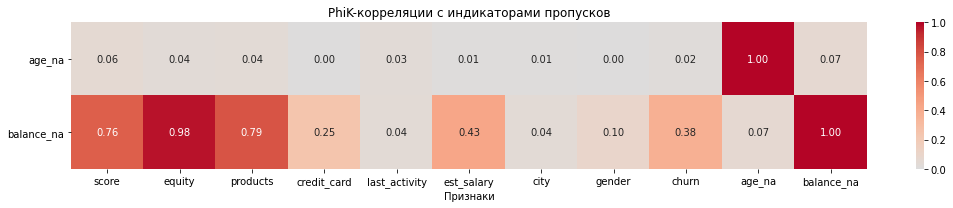

In [9]:
df_corr = df.drop(columns=['userid'])

interval_cols = ['score', 'age', 'balance', 'est_salary']

phik_matrix = df_corr.phik_matrix(interval_cols=interval_cols)

n_cols = ['score', 'equity', 'products', 'credit_card', 'last_activity', 'est_salary',
                'city','gender', 'churn', 'age_na', 'balance_na'] 
target_cols = ['age_na', 'balance_na']

phik_subset = phik_matrix.loc[target_cols, n_cols]

plt.figure(figsize=(15, 3))
sns.heatmap(
    phik_subset,
    cmap='coolwarm',
    center=0,
    vmin=0, vmax=1,
    annot=True,
    fmt='.2f'
)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title('PhiK-корреляции с индикаторами пропусков')
plt.xlabel('Признаки')
plt.tight_layout()
plt.show()

На матрице корреляции видно, что пропуски в столбце с возрастом появлись случайно, то есть их можно классифицировать как MCAR, такие пропуски мы удалим.

Пропуски с балансом на счёте имеют сильную корреляцию со столбцами equity (количество баллов собственности), products (количество продуктов, которыми пользуется клиент) и score (баллы кредитного скоринга), умеренную корреляцию о столбцами est_salary (оценочный доход клиента) и сhurn (признак оттока) и
слабую корреляцию со столбцом credit_card (наличие кредитной карты). Такие признаки уже относятся к MNAR, их мы оставим, чтобы не искажать данные.

In [10]:
df.dropna(subset=['age'], inplace=True) # удлаим пропуски в столбце с возрастом
df.info() # проверим результат

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         9974 non-null   int64  
 1   score          9974 non-null   float64
 2   city           9974 non-null   object 
 3   gender         9974 non-null   object 
 4   age            9974 non-null   float64
 5   equity         9974 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9974 non-null   int64  
 8   credit_card    9974 non-null   int64  
 9   last_activity  9974 non-null   int64  
 10  est_salary     9974 non-null   float64
 11  churn          9974 non-null   int64  
 12  age_na         9974 non-null   int64  
 13  balance_na     9974 non-null   int64  
dtypes: float64(4), int64(8), object(2)
memory usage: 1.1+ MB


Теперь приведём данные к нужному формату:

- баллы кредитного скоринга и возраст должны быть целыми числами

In [11]:
df['score'] = df['score'].astype(int)
df['age'] = df['age'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         9974 non-null   int64  
 1   score          9974 non-null   int64  
 2   city           9974 non-null   object 
 3   gender         9974 non-null   object 
 4   age            9974 non-null   int64  
 5   equity         9974 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9974 non-null   int64  
 8   credit_card    9974 non-null   int64  
 9   last_activity  9974 non-null   int64  
 10  est_salary     9974 non-null   float64
 11  churn          9974 non-null   int64  
 12  age_na         9974 non-null   int64  
 13  balance_na     9974 non-null   int64  
dtypes: float64(2), int64(10), object(2)
memory usage: 1.1+ MB


Отлично! Теперь всё корректно

Проверим наличие дубликатов

In [12]:
df.duplicated().sum()

0

Явных дубликатов нет, проверим неявные

In [13]:
df[df.duplicated(subset=['userid'])].count()

userid           50
score            50
city             50
gender           50
age              50
equity           50
balance          31
products         50
credit_card      50
last_activity    50
est_salary       50
churn            50
age_na           50
balance_na       50
dtype: int64

Значит у нас дублируются 50 userid, посмотрим на них

In [14]:
df[df.duplicated(subset=['userid'], keep=False)].sort_values(by='userid').head(10)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_na,balance_na
1893,116540,883,Рыбинск,Ж,55,1,362756.49,3,0,1,175920.48,1,0,0
7694,116540,887,Ярославль,Ж,38,0,NaN,1,0,1,119247.61,0,0,1
4866,117943,855,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1,0,0
7542,117943,880,Ярославль,Ж,40,0,NaN,1,1,0,137718.93,0,0,1
5863,120258,908,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1,0,0
5896,120258,905,Ярославль,М,30,0,NaN,1,1,1,146427.96,0,0,1
1411,123461,829,Ярославль,Ж,59,0,96222.44,2,0,1,102771.55,1,0,0
8638,123461,934,Рыбинск,М,34,0,NaN,2,1,0,291619.27,0,0,1
9775,124450,758,Рыбинск,Ж,36,0,73574.07,2,0,1,79963.59,0,0,0
8164,124450,859,Ярославль,Ж,38,6,516811.20,1,1,1,95144.63,1,0,0


Мы видим, что дублирование userid, вероятно, произошло из-за какого-то сбоя в системах между городами - один userid присвоен клиенту Рыбинска, а второй такой же - клиенту из Ярославля, при этом это разные клиенты - у них разные возраст, пол, количество продуктов и тд.

Проверим, есть ли клиенты с одинаковым user id, но разным оттоком

In [15]:
df[df.duplicated(subset=['userid','churn'], keep=False)]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_na,balance_na


Таких клиентов нет. Оставим дубликаты, они нам не помешают.

Осуществим кодирование признаков

In [16]:
df.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_na,balance_na
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,1
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0


In [17]:
df['city'].value_counts() # посмотрим какие города у нас представлены

Ярославль    5875
Рыбинск      2683
Ростов       1416
Name: city, dtype: int64

Закодируем столбцы с городом и полом:

* для пола и города применим one-hot кодирование 

In [18]:
df['city_original'] = df['city']
df['gender_original'] = df['gender']
df = pd.get_dummies(df, columns=['city'], prefix='city', dtype=int)

In [19]:
df = pd.get_dummies(df, columns=['gender'], prefix='gender', dtype=int)
df.head()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_na,balance_na,city_original,gender_original,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,183012,850,25,1,59214.82,2,0,1,75719.14,1,0,0,Рыбинск,Ж,0,1,0,1,0
1,146556,861,37,5,850594.33,3,1,0,86621.77,0,0,0,Рыбинск,Ж,0,1,0,1,0
2,120722,892,30,0,NaN,1,1,1,107683.34,0,0,1,Рыбинск,Ж,0,1,0,1,0
3,225363,866,51,5,1524746.26,2,0,1,174423.53,1,0,0,Ярославль,Ж,0,0,1,1,0
4,157978,730,34,5,174.00,1,1,0,67353.16,1,0,0,Ярославль,М,0,0,1,0,1


Отлично! Предобработка данных заверешена!
Что было сделано:
- приведены название столбцов к нижнему регистру
- проанализировали пропуски (убрали пропуски в столбце с возрастом, оставили пропуски в столбце с балансом)
- исправили типы данных у столбцов с баллами кредитного скоринга и возрастом
- выявили наличие неявных дубликатов по userid, но решили их оставить
- осуществили кодирование возраста (бинарное) и города (one-hot)

## 2) Проведём исследовательский анализ данных

Перед анализом клиентов в разрезе оттока интересно посмотреть на средние значения признаков для всех клиентов

In [20]:
df.describe()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_na,balance_na,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
count,9974.000000,9974.000000,9974.000000,9974.000000,7.695000e+03,9974.000000,9974.000000,9974.000000,9.974000e+03,9974.000000,9974.0,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000
mean,171755.218669,848.682575,42.734409,2.630840,8.272456e+05,1.871466,0.680168,0.522859,1.477868e+05,0.182374,0.0,0.228494,0.141969,0.268999,0.589031,0.499599,0.500401
std,33695.527126,65.399720,12.179971,1.979965,1.980327e+06,0.792729,0.466435,0.499502,1.392855e+05,0.386172,0.0,0.419884,0.349036,0.443462,0.492034,0.500025,0.500025
min,94561.000000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,142760.000000,802.000000,33.000000,0.000000,2.956987e+05,1.000000,0.000000,0.000000,7.525166e+04,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,172643.000000,853.000000,40.000000,3.000000,5.242953e+05,2.000000,1.000000,1.000000,1.196268e+05,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,201163.750000,900.000000,51.000000,4.000000,9.800512e+05,2.000000,1.000000,1.000000,1.744998e+05,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,229145.000000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- среднее значение баллов кредитного скоринга клиентов около 850
- среднее значение возраста 43 года, медианное - 40
- среднее значение баллов собственности - 3
- медианное значение баланса 520 тыс., а среднее - 827 тыс., значит есть аномально высокие значения баланса, которые смещают среднее в большую сторону
- медианное значение зарплаты 120 тыс., а среднее - 140 тыс., значит есть аномально высокие значения зарплаты, которые смещают среднее в большую сторону
- в среднем, у клиента 2 продукта
- у 68% есть кредитная карта
- 52% являются активными клиентами
- 18% оттока
- 59% клиентов из Ярославля, 27% - из Рыбинска, 14% - из Ростова

Также, вряд ли клиент банка может иметь 0 продуктов, то есть не иметь ни одного счёта и тд. Вероятно, это выброс

In [21]:
df['products'].value_counts()

2    5119
1    3323
3    1038
4     474
5      19
0       1
Name: products, dtype: int64

In [22]:
#удалим это аномальное значение
df = df.loc[df['products'] > 0]
df['products'].value_counts()

2    5119
1    3323
3    1038
4     474
5      19
Name: products, dtype: int64

Отлично!

Теперь посмотрим на распределение признаков в разрезе оттока

### **Распределение баланса клиентов по статусу оттока**

Прежде чем построить гистограмму, построим ящик с усами, тк при исследовании средних по банку значений мы предположили наличие выбросов в балансе, которые могут помешать читаемости гистограммы

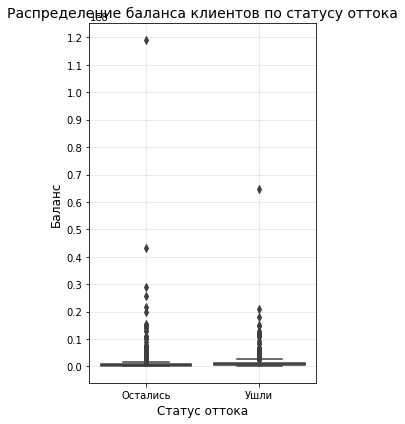

In [23]:
plt.figure(figsize=(4, 6))
sns.boxplot(x='churn', y='balance', data=df)

plt.title('Распределение баланса клиентов по статусу оттока', fontsize=14)
plt.xlabel('Статус оттока', fontsize=12)
plt.ylabel('Баланс', fontsize=12)
plt.xticks([0, 1], ['Остались', 'Ушли'])

min_balance = df['balance'].min()
max_balance = df['balance'].max()

plt.yticks(np.arange(np.floor(min_balance / 1e7) * 1e7, np.ceil(max_balance / 1e7) * 1e7 + 1e7, 1e7))

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Как мы и предполагали, у нас большое число аномальных значений баланса; для улучшения читаемости гистограммы, ограничим значения баланса 10 000 000

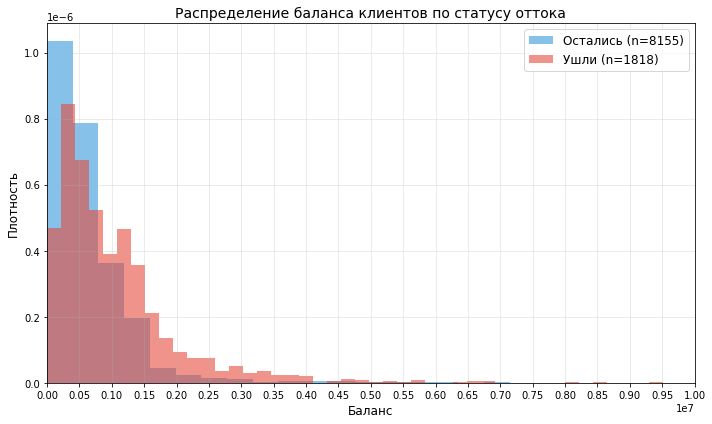

In [24]:
plt.figure(figsize=(10, 6))
colors = ['#3498db', '#e74c3c']
labels = ['Остались', 'Ушли']

for i, (churn, group) in enumerate(df.groupby('churn')):
    group['balance'].plot(kind='hist', alpha=0.6, bins=300, 
                     density=True, color=colors[i], 
                     label=f'{labels[i]} (n={len(group)})')
    
plt.title('Распределение баланса клиентов по статусу оттока', fontsize=14)
plt.xlabel('Баланс', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(0, 10_000_000)
plt.xticks(np.arange(0, 10000001, 500000)) 
plt.tight_layout()
plt.show()

Можно заметить, что ушедшие клиенты имели более высокий баланс, так после, примерно, 800 000 отток выше

### **Распределение дохода клиентов по статусу оттока**

Здесь также прежде чем построить гистограмму, построим ящик с усами, тк при исследовании средних по банку значений мы предположили наличие выбросов в балансе, которые могут помешать читаемости гистограммы

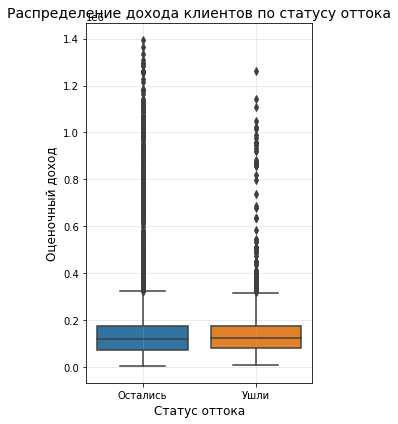

In [25]:
plt.figure(figsize=(4, 6))
sns.boxplot(x='churn', y='est_salary', data=df)

plt.title('Распределение дохода клиентов по статусу оттока', fontsize=14)
plt.xlabel('Статус оттока', fontsize=12)
plt.ylabel('Оценочный доход', fontsize=12)
plt.xticks([0, 1], ['Остались', 'Ушли'])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Как мы и предполагали, у нас большое число аномальных значений дохода; для улучшения читаемости гистограммы, ограничим значения дохода 800 000

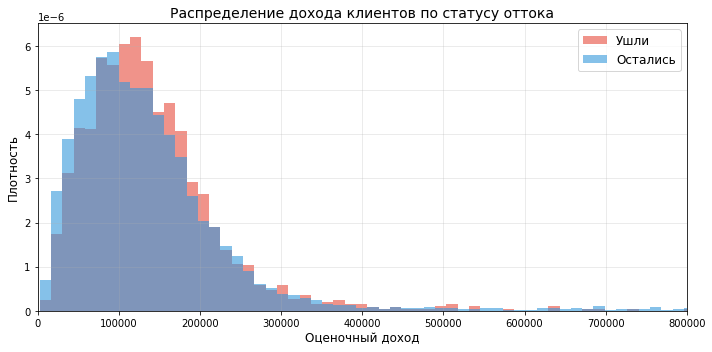

In [26]:
plt.figure(figsize=(10, 5))
colors = ['#3498db', '#e74c3c']
labels = ['Остались', 'Ушли']

plt.hist([df[df['churn'] == 0]['est_salary'], 
          df[df['churn'] == 1]['est_salary']], 
         bins=100, 
         density=True, 
         alpha=0.6, 
         color=colors,
         label=labels,
        histtype='stepfilled')
    
plt.title('Распределение дохода клиентов по статусу оттока', fontsize=14)
plt.xlabel('Оценочный доход', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(0, 800_000)
plt.xticks(np.arange(0, 800001, 100000)) 
plt.tight_layout()
plt.show()

Учитывая, что клиенты, которые покинули банк, имели более высокий баланс, вполне ожидаемо, что они также имели и более высокий доход, так от 100 000 примерно до 210 000 отток выше

### **Распределение баллов кредитного скоринга клиентов по статусу оттока**

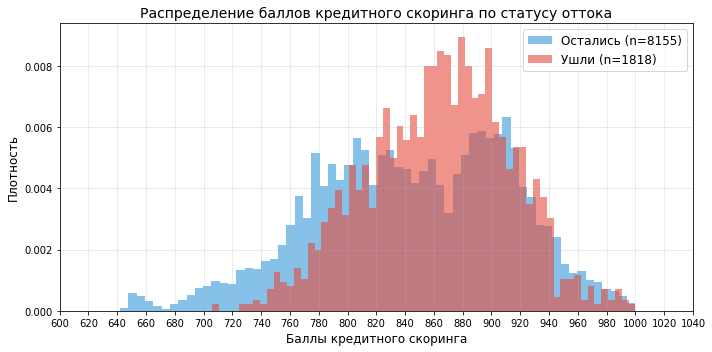

In [27]:
plt.figure(figsize=(10, 5))
colors = ['#3498db', '#e74c3c']
labels = ['Остались', 'Ушли']

for i, (churn, group) in enumerate(df.groupby('churn')):
    group['score'].plot(kind='hist', alpha=0.6, bins=62, 
                     density=True, color=colors[i], 
                     label=f'{labels[i]} (n={len(group)})')
    
plt.title('Распределение баллов кредитного скоринга по статусу оттока', fontsize=14)
plt.xlabel('Баллы кредитного скоринга', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(np.arange(600, 1050, 20)) 
plt.tight_layout()
plt.show()

Клиенты, которые покинули банк, имели среднее значение баллов кредитного скоринга, так в интервале примерно от 820 до 940 отток выше

### **Распределение возраста клиентов по статусу оттока**

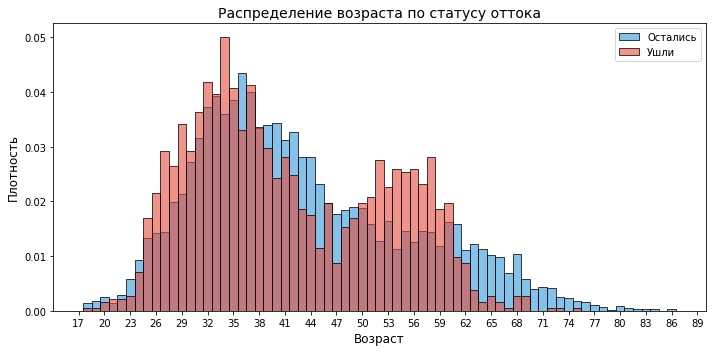

In [28]:
age_bins = list(range(df['age'].min(), df['age'].max() + 1, 2))

plt.figure(figsize=(10, 5))

sns.histplot(data=df[df['churn'] == 0], x='age', 
             bins=age_bins, binwidth=1,
             stat='density', discrete=True,
             alpha=0.6, 
             color='#3498db', 
             label='Остались')

sns.histplot(data=df[df['churn'] == 1], x='age', 
             bins=age_bins, binwidth=1, 
             stat='density', discrete=True,
             alpha=0.6, 
             color='#e74c3c', 
             label='Ушли')

plt.title('Распределение возраста по статусу оттока', fontsize=14)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.xticks(np.arange(17, 92, 3))
plt.legend()
plt.tight_layout()
plt.show()

Можно выделить две возрастные группы ушедших клиентов: от 25 до 35 и от 50 до 60

### **Анализ долей оттока по баллам собственности клиентов**

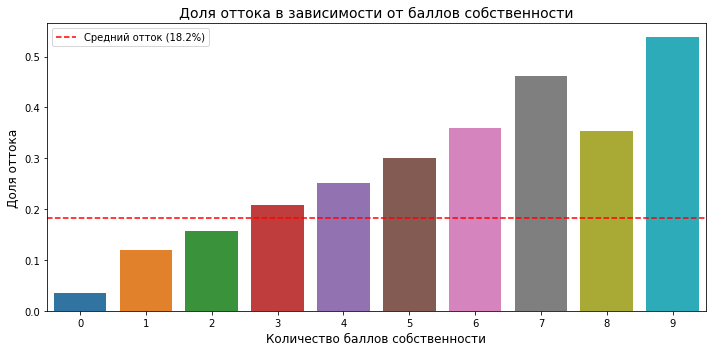

In [29]:
equity_total = df.groupby('equity').size().reset_index(name='total_count')

equity_churned = df[df['churn'] == 1].groupby('equity').size().reset_index(name='churn_count')

equity_stats = pd.merge(equity_total, equity_churned, on='equity', how='left')
equity_stats['churn_count'] = equity_stats['churn_count'].fillna(0)

equity_stats['churn_rate'] = equity_stats['churn_count'] / equity_stats['total_count']
average_churn = df['churn'].mean()

plt.figure(figsize=(10, 5))

sns.barplot(data=equity_stats, x='equity', y='churn_rate')

plt.axhline(average_churn, color='red', linestyle='--', label=f'Средний отток ({average_churn:.1%})')

plt.title('Доля оттока в зависимости от баллов собственности', fontsize=14)
plt.xlabel('Количество баллов собственности', fontsize=12)
plt.ylabel('Доля оттока', fontsize=12)
plt.xticks(ticks=sorted(df['equity'].unique()))
plt.legend()
plt.tight_layout()
plt.show()

Ушедшие клиенты, вероятно, имели больше собственности, чем оставшиеся клиенты, так от 3 до 9 баллов собственности отток выше

### **Анализ долей оттока по количеству продуктов клиентов**

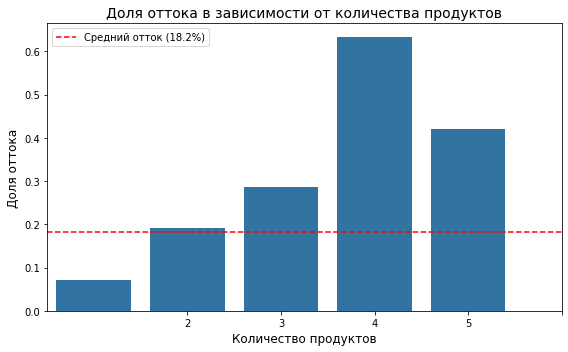

In [30]:
products_total = df.groupby('products').size().reset_index(name='total_count')
products_churned = df[df['churn'] == 1].groupby('products').size().reset_index(name='churn_count')

products_stats = pd.merge(products_total, products_churned, on='products', how='left')
products_stats['churn_count'] = products_stats['churn_count'].fillna(0)
products_stats['churn_rate'] = products_stats['churn_count'] / products_stats['total_count']
average_churn = df['churn'].mean()

plt.figure(figsize=(8, 5))

sns.barplot(data=products_stats, x='products', y='churn_rate', color='tab:blue')

plt.axhline(average_churn, color='red', linestyle='--', label=f'Средний отток ({average_churn:.1%})')

plt.title('Доля оттока в зависимости от количества продуктов', fontsize=14)
plt.xlabel('Количество продуктов', fontsize=12)
plt.ylabel('Доля оттока', fontsize=12)
plt.xticks(ticks=sorted(df['products'].unique()))
plt.legend()
plt.tight_layout()
plt.show()

Ушедшие клиенты имели больше продуктов, так от 2 до 5 продуктов отток выше

### **Анализ долей оттока по наличию кредитной карты**

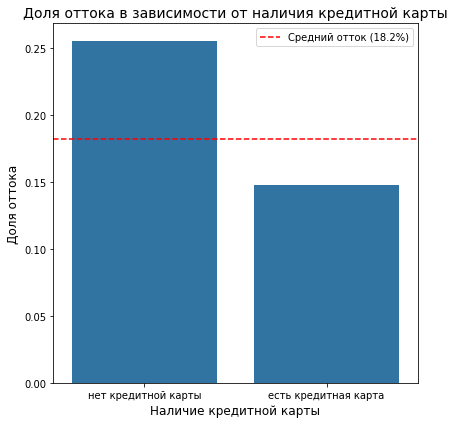

In [31]:
credit_total = df.groupby('credit_card').size().reset_index(name='total_count')
credit_churned = df[df['churn'] == 1].groupby('credit_card').size().reset_index(name='churn_count')

credit_stats = pd.merge(credit_total, credit_churned, on='credit_card', how='left')
credit_stats['churn_count'] = credit_stats['churn_count'].fillna(0)
credit_stats['churn_rate'] = credit_stats['churn_count'] / credit_stats['total_count']
average_churn = df['churn'].mean()

plt.figure(figsize=(6, 6))

sns.barplot(data=credit_stats, x='credit_card', y='churn_rate', color='tab:blue')

plt.axhline(average_churn, color='red', linestyle='--', label=f'Средний отток ({average_churn:.1%})')

plt.title('Доля оттока в зависимости от наличия кредитной карты', fontsize=14)
plt.xlabel('Наличие кредитной карты', fontsize=12)
plt.ylabel('Доля оттока', fontsize=12)
plt.xticks(ticks=[0, 1], labels=["нет кредитной карты", "есть кредитная карта"])
plt.legend()
plt.tight_layout()
plt.show()

Ушедшие клиенты реже имели кредитную карту

### **Анализ долей оттока по статусу активности клиентов**

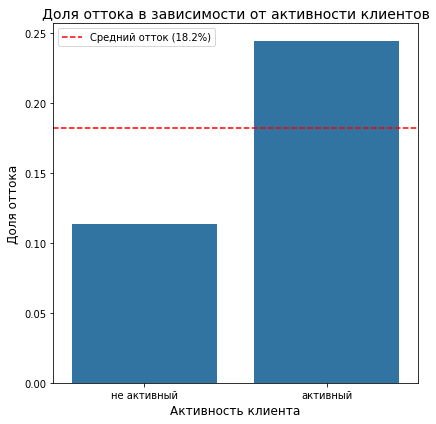

In [32]:
activity_total = df.groupby('last_activity').size().reset_index(name='total_count')
activity_churned = df[df['churn'] == 1].groupby('last_activity').size().reset_index(name='churn_count')
activity_stats = pd.merge(activity_total, activity_churned, on='last_activity', how='left')
activity_stats['churn_count'] = activity_stats['churn_count'].fillna(0)
activity_stats['churn_rate'] = activity_stats['churn_count'] / activity_stats['total_count']
average_churn = df['churn'].mean()

plt.figure(figsize=(6, 6))
sns.barplot(data=activity_stats, x='last_activity', y='churn_rate', color='tab:blue')
plt.axhline(average_churn, color='red', linestyle='--', label=f'Средний отток ({average_churn:.1%})')
plt.title('Доля оттока в зависимости от активности клиентов', fontsize=14)
plt.xlabel('Активность клиента', fontsize=12)
plt.ylabel('Доля оттока', fontsize=12)
plt.xticks(ticks=[0, 1], labels=["не активный", "активный"])
plt.legend()
plt.tight_layout()
plt.show()


Большинство ушедших клиентов были активными

### **Анализ долей оттока по полу клиентов**

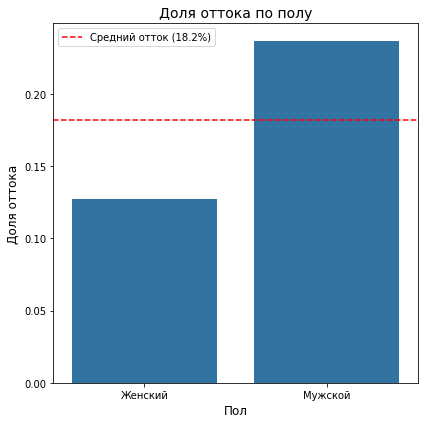

In [33]:
gender_total = df.groupby('gender_original').size().reset_index(name='total_count')
gender_churned = df[df['churn'] == 1].groupby('gender_original').size().reset_index(name='churn_count')
gender_stats = pd.merge(gender_total, gender_churned, on='gender_original', how='left')
gender_stats['churn_count'] = gender_stats['churn_count'].fillna(0)
gender_stats['churn_rate'] = gender_stats['churn_count'] / gender_stats['total_count']
average_churn = df['churn'].mean()

plt.figure(figsize=(6, 6))
sns.barplot(data=gender_stats, x='gender_original', y='churn_rate', color='tab:blue')
plt.axhline(average_churn, color='red', linestyle='--', label=f'Средний отток ({average_churn:.1%})')
plt.title('Доля оттока по полу', fontsize=14)
plt.xlabel('Пол', fontsize=12)
plt.ylabel('Доля оттока', fontsize=12)
plt.xticks(ticks=[0, 1], labels=["Женский", "Мужской"])
plt.legend()
plt.tight_layout()
plt.show()

Мужчины более склонны к оттоку

### **Анализ долей оттока по городам**

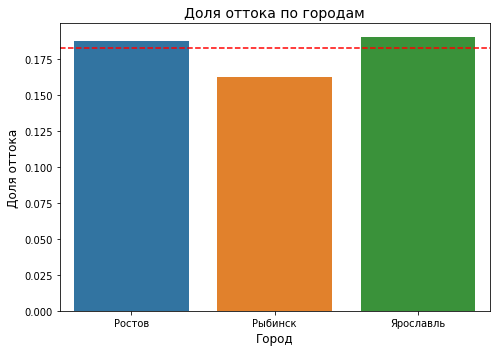

In [34]:
city_total = df.groupby('city_original').size().reset_index(name='total_count')

city_churned = df[df['churn'] == 1].groupby('city_original').size().reset_index(name='churn_count')

city_stats = pd.merge(city_total, city_churned, on='city_original', how='left')
city_stats['churn_count'] = city_stats['churn_count'].fillna(0) 

city_stats['churn_rate'] = city_stats['churn_count'] / city_stats['total_count']

plt.figure(figsize=(7, 5))
average_churn = df['churn'].mean()

sns.barplot(data=city_stats, x='city_original', y='churn_rate')
plt.axhline(average_churn, color='red', linestyle='--', label=f'Средний отток ({average_churn:.1%})')


plt.title('Доля оттока по городам', fontsize=14)
plt.xlabel('Город', fontsize=12)
plt.ylabel('Доля оттока', fontsize=12)
plt.tight_layout()
plt.show()

Жители Ярославля и Ростова более склонны к оттоку

Анализ признаков в разрезе оттока показал:

1) отточные интервалы:
    - баланс более 800 000
    - доход 100 000 - 210 000
    - баллы кредитного скоринга 820 - 940
    - возраст 25 - 35 и 50 - 60
    - баллы собственности 3 - 9
    - количество продуктов 2 - 5

2) значения признаков клиентов, более склонных к оттоку:
    - отсутствие кредитной карты
    - активный клиент
    - мужчина
    - житель Ярославля или Ростова

### Проведём корреляционный анализ 

Посчитаем корреляцию Пирсона и выведем результат в виде тепловой карты

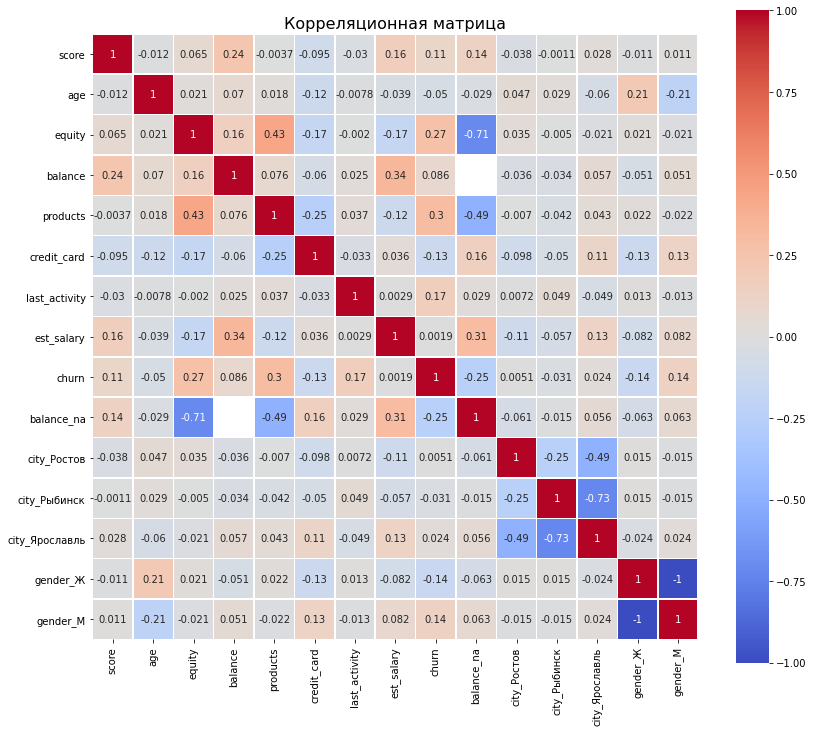

In [35]:
numeric_columns = df.columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in ['city_original', 'gender_original','userid', 'age_na']]

correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, 
            annot=True,    
            cmap='coolwarm',  
            center=0,        
            vmin=-1, 
            vmax=1,
            square=True,      
            linewidths=0.5,   
            cbar_kws={"shrink": .8})  

plt.title('Корреляционная матрица', fontsize=16)
plt.tight_layout()
plt.show()

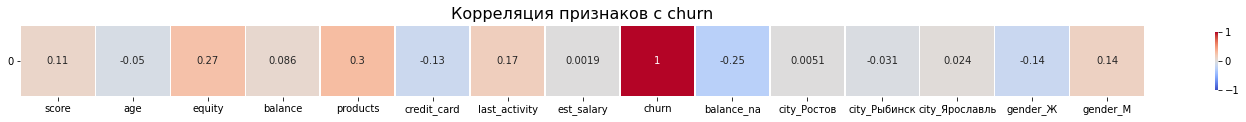

In [36]:
numeric_columns = df.columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in ['city_original', 'gender_original','userid', 'age_na']]

numeric_columns = df[numeric_columns].select_dtypes(include='number').columns.tolist()

correlation_with_churn = df[numeric_columns].corrwith(df['churn'])

plt.figure(figsize=(20, 1.8))
sns.heatmap(correlation_with_churn.to_frame().T, 
            annot=True, 
            cmap='coolwarm', 
            center=0, 
            vmin=-1, 
            vmax=1, 
            linewidths=0.5,
            cbar_kws={"shrink": .8})

plt.title('Корреляция признаков с churn', fontsize=16)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Корреляции с признаком оттока:
- наблюдается слабая связь между оттоком и количеством баллов собственности; возможно, ушедшие клиенты имели больше собственности
- также, наблюдается умеренная связь между оттоком и количеством продуктов; вероятно, ушедшие клиенты имели больше продуктов банка
- можно отметить слабую отрицательную корреляцию между оттоком и пропусками в балансе клиента; возможно, у ушедших клиентов реже наблюдались пропуски в данных о балансе

Корреляции между другими признаками:
- наблюдается умеренная связь между количеством продуктов и количеством баллов собственности
- также между балансом и оценочным доходом имеется умеренная связь
- между наличием кредитной карты и количеством продуктов банка имеется солабая отрицательная корреляция
- ожидаемо наблюдается слабая корреляция между количеством баллов кредитного скоринга и балансом, оценочным доходом
- пропуски в балансе умеренно положтельно коррелируют с оценочным доходом, умеренно отрицательно с количеством продуктов и сильно отрицательно с количеством баллов собственности

Остальные признаки либо не коррелируют между собой, либо корреляция слабая

Посчитаем корреляцию phik и сравним результаты с корреляцией Пирсона

In [37]:
df_corr = df.drop(columns=['userid', 'age_na', 'gender_М', 'gender_Ж'])

In [38]:
phik_matrix = df_corr.phik_matrix(interval_cols=['age', 'balance', 'score', 'est_salary'])

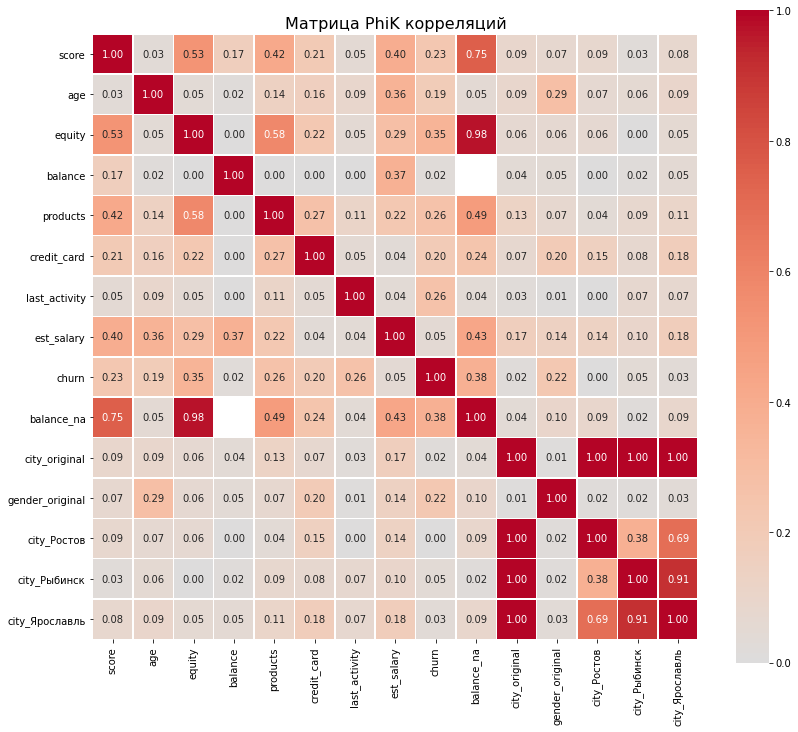

In [39]:
# Отрисовка
plt.figure(figsize=(12, 12))
sns.heatmap(phik_matrix, 
            annot=True, 
            fmt=".2f",
            cmap='coolwarm', 
            center=0, 
            square=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": .8})

plt.title('Матрица PhiK корреляций', fontsize=16)
plt.tight_layout()
plt.show()

В целом, подтверждаются ранее выявленные зависимости и многие из них имеют более высокую корреляцию:

Заметная корреляция (больше ~ 0.5) между:
- баллами кредитного скоринга и баллами собственности, балансом и зарплатой 
- баллами собственности и количеством продуктов

Отдельно выделим корреляцию пропусков в балансе:
- сильная корреляция наблюдается с баллами собственности, баллами кредитного скоринга
- умеренная корреляция с количеством продуктов, зарплатой, оттоком

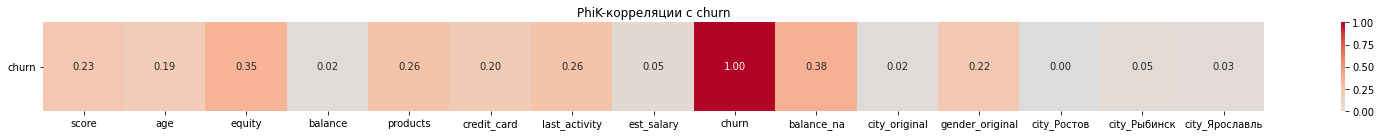

In [40]:
df_corr = df.drop(columns=['userid', 'age_na', 'gender_М', 'gender_Ж'])
phik_matrix = df_corr.phik_matrix(interval_cols=['age', 'balance', 'score', 'est_salary'])
numeric_cols = df_corr.columns.tolist()
target_cols = ['churn']

phik_subset = phik_matrix.loc[target_cols, numeric_cols]

plt.figure(figsize=(22, 2))
sns.heatmap(
    phik_subset,
    cmap='coolwarm',
    center=0,
    vmin=0, vmax=1,
    annot=True,
    fmt='.2f'
)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title('PhiK-корреляции с churn')
plt.tight_layout()
plt.show()

В целом, подтверждаются ранее выявленные зависимости и многие из них имеют более высокую корреляцию:

- отток также умеренно коррелирует с баллами собственности и пропусками в балансе, а к слабой корреляции с количеством продуктов добавляются признаки: баллы кредитного скоринга, возраст, наличие/отсутствие кредитной карты, активность и пол

### **Составим портреты клиентов, склонных и не склонных к уходу**

In [41]:
grouped_stats = df.groupby('churn').agg({'score': ['mean', 'median'],  
                        'age': ['mean', 'median'],               
                        'balance': ['mean', 'median'],  
                        'est_salary': ['mean', 'median'], 
                        'gender_original': lambda x: x.mode()[0], 
                        'equity': 'median', 
                        'products': 'median', 
                        'credit_card': 'median', 
                        'last_activity': 'median', 
                        'city_original': lambda x: x.mode()[0]})

grouped_stats.columns = ["_".join(col).strip('_') if isinstance(col, tuple) and col[1] else col[0] for col in grouped_stats.columns.values]
result = grouped_stats.T

result.columns.name = 'Показатель' 
col0, col1 = result.columns[0], result.columns[1] 
mean_rows_idx = result.index[result.index.str.contains('_mean')]
result.loc[mean_rows_idx, [col0, col1]] = result.loc[mean_rows_idx, [col0, col1]].astype(float).round(2)
relative_diff_means = (result.loc[mean_rows_idx, col1].astype(float) - result.loc[mean_rows_idx, col0].astype(float))/ \
                        result.loc[mean_rows_idx, col0].astype(float)

result['relative_difference'] = np.nan
result.loc[mean_rows_idx, 'relative_difference'] = relative_diff_means

index_rename_map = {
    'score_mean': 'Средний балл кредитного скоринга',
    'score_median': 'Медианный балл кредитного скоринга',
    'age_mean': 'Средний возраст',
    'age_median': 'Медианный возраст',
    'balance_mean': 'Среднее значение баланса',
    'balance_median': 'Медианное значение баланса',
    'est_salary_mean': 'Средняя оценочная зарплата',
    'est_salary_median': 'Медианная оценочная зарплата',
    'gender_original_<lambda>': 'Мода по полу',
    'equity_median': 'Медианное значение баллов собственности', 
    'products_median': 'Медианное кол-во продуктов',
    'credit_card_median': 'Наличие кредитной карты (медиана)',
    'last_activity_median': 'Активность клиента (медиана)',
    'city_original_<lambda>': 'Мода по городу'
}
result.rename(index=index_rename_map, inplace=True)
result.rename(columns={col0: 'Остались', col1: 'Ушли', 'relative_difference': 'Относительная разница'}, inplace=True)

if 'Относительная разница' in result.columns:
      result['Относительная разница'] = result['Относительная разница'].apply(lambda x: '{:.2%}'.format(x) if pd.notna(x) else x)
      result['Относительная разница'] = result['Относительная разница'].fillna('-')

with pd.option_context('display.expand_frame_repr', False,
                       'display.width', 0,
                       'display.max_columns', None):
    display(result)

Показатель,Остались,Ушли,Относительная разница
Средний балл кредитного скоринга,845.4,863.36,2.12%
Медианный балл кредитного скоринга,848,866,-
Средний возраст,43.02,41.43,-3.70%
Медианный возраст,40,39,-
Среднее значение баланса,733031.63,1134458.21,54.76%
Медианное значение баланса,475410.09,783908.9,-
Средняя оценочная зарплата,147674.64,148357.48,0.46%
Медианная оценочная зарплата,118227.6,125408.88,-
Мода по полу,Ж,М,-
Медианное значение баллов собственности,3,4,-


Наиболее явно различаются баланс, пол и активность клиента: в среднем, ушедшие клиенты имеют более высокое значение баланса, чаще мужской пол, являются активными клиентами и имеют большее количество баллов собственности

Также, ушедшие клиенты, в среднем, младше оставшихся клиентов, пользуются большим количеством продуктов и имеют более высокую зарплату.

Различия в баллах скоринга, количестве продуктов и зарплате (оценочном доходе) проверим статистически

**Портрет лояльного клиента:**

- неактивная клиентка-женщина 43 лет из Ярославля, которая пользуется двумя продуктами банка, имеет кредитную карту, 3 балла собственности, заработную плату около 147 000, баланс около 733 000 и 845 баллов кредитного скоринга

**Портрет отточного клиента:**

- активный клиент-мужчина 41 года из Ярославля, который пользуется двумя продуктами банка, имеет кредитную карту, 4 балла собственности, заработную плату около 148 000, баланс около 1 134 000 и 863 баллов кредитного скоринга

## 3) Проверим гипотезы

Перед проверкой гипотез, проверим, можем ли мы использовать стандартный тест Стьюдента

Проанализируем выбросы

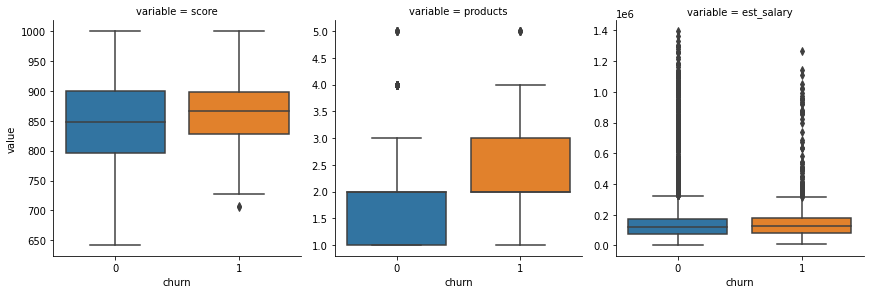

In [42]:
cols = ['score', 'products', 'est_salary']

sns.catplot(
    data=df.melt(id_vars='churn', value_vars=cols),
    x='churn', y='value',
    col='variable',
    kind='box',
    sharey=False,
    height=4,       
    aspect=1       
)
plt.show()

In [43]:
# избавимся от выбросов
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

filtered_df = df.copy()
for col in ['score', 'products', 'est_salary']:
    filtered_df = remove_outliers_iqr(filtered_df, col)

In [44]:
# разделим данные на две независимые выборки по признаку оттока
churned = filtered_df[filtered_df['churn'] == 1]
not_churned = filtered_df[filtered_df['churn'] == 0]

print(f"Размер выборки churned: {len(churned)}")
print(f"Размер выборки not_churned: {len(not_churned)}")

Размер выборки churned: 1451
Размер выборки not_churned: 7543


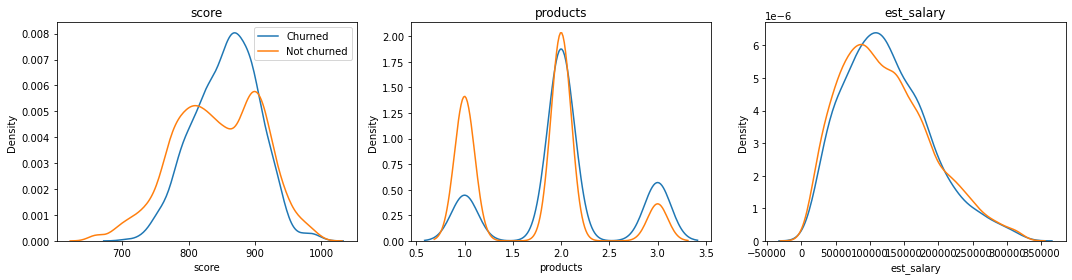

In [45]:
# проверим на нормальность
cols = ['score', 'products', 'est_salary']

plt.figure(figsize=(15, 4))  

for i, col in enumerate(cols, 1):
    plt.subplot(1, 3, i)      
    sns.kdeplot(churned[col],     label='Churned')
    sns.kdeplot(not_churned[col], label='Not churned')
    plt.title(col)
    if i == 1:
        plt.legend()           
    else:
        plt.legend([],[], frameon=False)  

plt.tight_layout()
plt.show()

Распределения не нормальные, но выборки большие (ЦПТ) - используем t-тест, но разница между выборками больше 25%, значит будем использовать t-тест с поправкой Уэлча

1) **Нулевая гипотеза:** средние доходы ушедших и оставшихся клиентов *одинаковые*
   
   **Альтернативная гипотеза:** средние доходы ушедших и оставшихся клиентов *различаются*

In [46]:
alpha = 0.05 # берём наиболее универсальный уровень статистической значимости

results = st.ttest_ind(
    not_churned['est_salary'], 
    churned['est_salary'],
    equal_var=False  
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние доходы ушедших и оставшихся клиентов различаются')
else:
    print('Не получилось отвергнуть нулевую гипотезу: средние доходы ушедших и оставшихся клиентов не имеют статистически значимой разницы')

p-значение: 0.26390424038272225
Не получилось отвергнуть нулевую гипотезу: средние доходы ушедших и оставшихся клиентов не имеют статистически значимой разницы


2) **Нулевая гипотеза:** средние баллы кредитного скоринга ушедших и оставшихся клиентов *одинаковые*
   
   **Альтернативная гипотеза:** средние баллы кредитного скоринга ушедших и оставшихся клиентов *различаются*

In [47]:
alpha = 0.05 

results = st.ttest_ind(
    not_churned['score'], 
    churned['score'],
    equal_var=False  
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние баллы кредитного скоринга ушедших и оставшихся клиентов различаются')
else:
    print('Не получилось отвергнуть нулевую гипотезу: средние баллы кредитного скоринга ушедших и оставшихся клиентов не имеют статистически значимой разницы')

p-значение: 4.676191456014403e-17
Отвергаем нулевую гипотезу: средние баллы кредитного скоринга ушедших и оставшихся клиентов различаются


3) **Нулевая гипотеза:** средние баллы кредитного скоринга ушедших клиентов *не выше* баллов оставшихся клиентов 
   
   **Альтернативная гипотеза:** средние баллы кредитного скоринга ушедших клиентов *выше* баллов оставшихся клиентов 

In [48]:
alpha = 0.05 

results = st.ttest_ind(
    churned['score'], 
    not_churned['score'],
    equal_var=False,
    alternative='greater' 
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние баллы кредитного скоринга ушедших клиентов выше баллов оставшихся клиентов')
else:
    print('Не получилось отвергнуть нулевую гипотезу: средние баллы кредитного скоринга ушедших и оставшихся клиентов не имеют статистически значимой разницы')

p-значение: 2.3380957280072014e-17
Отвергаем нулевую гипотезу: средние баллы кредитного скоринга ушедших клиентов выше баллов оставшихся клиентов


4) **Нулевая гипотеза:** средние количества продуктов ушедших и оставшихся клиентов *одинаковые*
   
   **Альтернативная гипотеза:** средние количества продуктов ушедших и оставшихся клиентов *отличаются*

In [49]:
alpha = 0.05 

results = st.ttest_ind(
    not_churned['products'], 
    churned['products'],
    equal_var=False  
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние количества продуктов ушедших и оставшихся клиентов отличаются')
else:
    print('Не получилось отвергнуть нулевую гипотезу: средние количества продуктов ушедших и оставшихся клиентов не имеет статистически значимой разницы')

p-значение: 1.2649994844060092e-71
Отвергаем нулевую гипотезу: средние количества продуктов ушедших и оставшихся клиентов отличаются


5) **Нулевая гипотеза:** среднее количество продуктов ушедших клиентов *не больше* среднего количества продуктов оставшихся клиентов 
   
   **Альтернативная гипотеза:** среднее количество продуктов ушедших клиентов *больше* среднего количества продуктов оставшихся клиентов 

In [50]:
alpha = 0.05 
results = st.ttest_ind(
    churned['products'], 
    not_churned['products'],
    equal_var=False,
    alternative='greater'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: среднее количество продуктов ушедших клиентов больше среднего количества продуктов оставшихся клиентов')
else:
    print('Не получилось отвергнуть нулевую гипотезу: средние количества продуктов ушедших и оставшихся клиентов не имеет статистически значимой разницы')

p-значение: 6.324997422030046e-72
Отвергаем нулевую гипотезу: среднее количество продуктов ушедших клиентов больше среднего количества продуктов оставшихся клиентов


**По результатам проверки статистических гипотез, мы можем сказать, что:**

- средние доходы ушедших и оставшихся клиентов не имеют статистически значимой разницы
- в среднем, ушедшие клиенты имели более высокие баллы кредитного скоринга
- среднее количество продуктов ушедших клиентов больше среднего количества продуктов оставшихся клиентов

## 4) Подведём промежуточные итоги

**Результаты исследовательского анализа данных (EDA):**
1)  интервалы с большим оттоком:
    - баланс более 800 000
    - доход 100 000 - 210 000
    - баллы кредитного скоринга 820 - 940
    - возраст 25 - 35 и 50 - 60
    - баллы собственности 3 - 9
    - количество продуктов 2 - 5

2) значения признаков клиентов, более склонных к оттоку:
    - отсутствие кредитной карты
    - активный клиент
    - мужчина
    - житель Ярославля

**Результаты корреляционного анализа:**

- наблюдается слабая связь между оттоком и **количеством баллов собственности**; возможно, ушедшие клиенты имели больше собственности
- также, наблюдается умеренная связь между оттоком и **количеством продуктов**; вероятно, ушедшие клиенты имели больше продуктов банка
- можно отметить слабую отрицательную корреляцию между оттоком и пропусками в балансе клиента; возможно, у ушедших клиентов реже наблюдались пропуски в данных о балансе
  
**Результаты составления портретов клиентов:**

*Портрет лояльного клиента:*

- неактивная клиентка-женщина 43 лет из Ярославля, которая пользуется двумя продуктами банка, имеет кредитную карту, 3 балла собственности, заработную плату около 147 000, баланс около 733 000 и 845 баллов кредитного скоринга

*Портрет отточного клиента:*

- активный клиент-мужчина 41 года из Ярославля, который пользуется двумя продуктами банка, имеет кредитную карту, 4 балла собственности, заработную плату около 148 000, баланс около 1 134 000 и 863 баллов кредитного скоринга

- также, при составлении протретов ушедших и оставшихся клиентов, наиболее явно различались: **баланс, пол и активность клиента**
  
**Результаты проверки статистических гипотез:**

- средние доходы ушедших и оставшихся клиентов не имеют статистически значимой разницы
- в среднем, ушедшие клиенты имели более высокие баллы кредитного скоринга
- среднее количество продуктов ушедших клиентов больше среднего количества продуктов оставшихся клиентов

**Таким образом, на сегментирующие признаки:**
- количество баллов кредитного скоринга *(820 - 940)*
- баланс *(более 800 000)*
- количество продуктов *(2 - 5)*
- количество баллов собственности *(3 - 9)*
  
дополнительные признаки для сегментации:

- активность клиента *(активный клиент)*
- пол *(мужской)*

## 5) Осуществим сегментацию клиентов

Для начала попробуем отфильтровать датафрейм по двум признакам, с помощью квартилей выделим группы и посмотрим на процент оттока и количество клиентов в этих группах

In [51]:
df_churn = df.copy() #создадим копию даатфрейма

Последовательно подберём признаки для срезов

In [52]:
df1 = df_churn.loc[(df['equity']  >= 3) & (df_churn['last_activity'] == 1) & (df['gender_М']  == 1)]
print('Сегмент 1: Процент оттока', round(df1['churn'].mean() *100 ,2), '%,', 'Количество клиентов', df1['userid'].count())

Сегмент 1: Процент оттока 46.16 %, Количество клиентов 1408


In [53]:
df2 = df_churn.loc[(df['balance'] > 800000) & (df['gender_М']  == 1) &  ~(df['userid'].isin(df1['userid']))]
print('Сегмент 2: Процент оттока', round(df2['churn'].mean() *100 , 2), '%,', 'Количество клиентов', df2['userid'].count())

Сегмент 2: Процент оттока 31.73 %, Количество клиентов 665


In [54]:
df3 = df_churn.loc[ (df['products'] >= 2) & (df_churn['score'] >= 820) & \
                   (df_churn['score'] <= 940)  & ~(df['userid'].isin(df1['userid'])) & ~(df['userid'].isin(df2['userid']))]
print('Сегмент 3: Процент оттока', round(df3['churn'].mean() *100 ,2), '%,', 'Количество клиентов', df3['userid'].count())

Сегмент 3: Процент оттока 20.78 %, Количество клиентов 2820


Мы видим в последнем сегменте большое количество клиентов и невысокий процент оттока, попробуем изменить ограничение по количеству продуктов (если мы вернёмся к графику доли оттока по количеству продуктов, то заметим, что при двух продуктах отток не очень отличается от среднего по банку, как уже при трёх продуктах, поэтому такое смещение интервала, как я считаю, некритично)

In [55]:
df3 = df_churn.loc[ (df['products'] >= 3) & (df_churn['score'] >= 820) &  \
                   (df_churn['score'] <= 940) & ~(df['userid'].isin(df1['userid'])) & ~(df['userid'].isin(df2['userid']))]
print('Сегмент 3: Процент оттока', round(df3['churn'].mean() *100 ,2), '%,', 'Количество клиентов', df3['userid'].count())

Сегмент 3: Процент оттока 34.14 %, Количество клиентов 577


In [56]:
# проверим, что userid не повторяется
s1 = set(df1['userid'])
s2 = set(df2['userid'])
s3 = set(df3['userid'])

# попарные пересечения
common_12 = s1 & s2
common_13 = s1 & s3
common_23 = s2 & s3

print("df1 ∩ df2:", common_12)
print("df1 ∩ df3:", common_13)
print("df2 ∩ df3:", common_23)

if not (common_12 or common_13 or common_23):
    print("userid уникальны")
else:
    print("есть дубликаты userid")

df1 ∩ df2: set()
df1 ∩ df3: set()
df2 ∩ df3: set()
userid уникальны


### Приоретизация

Следует начать с клиентов из сегмента с наибольшим процентом оттока и далее по убыванию процента оттока

In [57]:
print('Первым будет сегмент 1: Процент оттока', round(df1['churn'].mean() *100 ,2), '%,', 'Количество клиентов', df1['userid'].count())
print('Вторым будет сегмент 3: Процент оттока', round(df3['churn'].mean() *100 ,2), '%,', 'Количество клиентов', df3['userid'].count())
print('Третьим будет сегмент 2: Процент оттока', round(df2['churn'].mean() *100 , 2), '%,', 'Количество клиентов', df2['userid'].count())

Первым будет сегмент 1: Процент оттока 46.16 %, Количество клиентов 1408
Вторым будет сегмент 3: Процент оттока 34.14 %, Количество клиентов 577
Третьим будет сегмент 2: Процент оттока 31.73 %, Количество клиентов 665


## 6) Рекомендации

1) В первый сегмент попали активные клиенты-мужчины с баллами недвижимости от 3-х и больше. Для них можно разработать партнерские программы с автосервисами или страховыми компаниями. Например, предложить скидку 10–15% на техобслуживание автомобиля через приложение банка, добавить возможность оформления страхования автомобиля прямо в мобильном приложении банка с кэшбэком 5%. Также, учитывая высокий балл недвижимости, можно предложить льготное страхование жилья (например, со скидкой 20%) и специальные условия по рефинансированию ипотеки.

2) Во втором сегменте у нас клиенты-мужчины с высокими балансом (800 000 +), им можно предложить персональные увеличенные процентные ставки на вклады на определённый срок (например, +2–3% к текущей рыночной ставке на 6 месяцев) или специальные инвестиционные портфели с минимальным риском и гарантированной доходностью (например, 10–12% годовых). 

3) В третьем сегменте у нас клиенты, пользующиеся тремя и более продуктами банка и имеющие высокие баллы кредитного скоринга (820+). Для них можно внедрить программу лояльности для владельцев 3-х и более продуктов, где клиенты получают дополнительные баллы за использование продукта (баллы можно обменивать на скидки, кэшбэк или другие бонусы) или имеют повышенный кешбэк, или предложить льготные условия кредитования (снижение процентной ставки на 1–2%).

Общая рекомендация: провести опрос и выяснить, почему банк покидают такие прибыльные клиенты (с высоким балансом, высокими баллами кредитного скоринга и тд.)

# Общий вывод 

**Выводы по анализу признаков в разрезе оттока:**

1) отточные интервалы:
    - баланс более 800 000
    - доход 100 000 - 210 000
    - баллы кредитного скоринга 820 - 940
    - возраст 25 - 35 и 50 - 60
    - баллы собственности 3 - 9
    - количество продуктов 2 - 5

2) значения признаков клиентов, более склонных к оттоку:
    - отсутствие кредитной карты
    - активный клиент
    - мужчина
    - житель Ярославля

**Вывводы по корреляционному анализу:**

Корреляции с признаком оттока:
- наблюдается слабая связь между оттоком и количеством баллов собственности; возможно, ушедшие клиенты имели больше собственности
- также, наблюдается умеренная связь между оттоком и количеством продуктов; вероятно, ушедшие клиенты имели больше продуктов банка
- можно отметить слабую отрицательную корреляцию между оттоком и пропусками в балансе клиента; возможно, у ушедших клиентов реже наблюдались пропуски в данных о балансе

Корреляции между другими признаками:
- наблюдается умеренная связь между количеством продуктов и количеством баллов собственности
- также между балансом и оценочным доходом имеется умеренная связь
- между наличием кредитной карты и количеством продуктов банка имеется солабая отрицательная корреляция
- ожидаемо наблюдается слабая корреляция между количеством баллов кредитного скоринга и балансом, оценочным доходом
- пропуски в балансе умеренно положительно коррелируют с оценочным доходом, умеренно отрицательно с количеством продуктов и сильно отрицательно с количеством баллов собственности

Остальные признаки либо не коррелируют между собой, либо корреляция слабая

**Результаты составления портретов клиентов:**

*Портрет лояльного клиента:*

- неактивная клиентка-женщина 43 лет из Ярославля, которая пользуется двумя продуктами банка, имеет кредитную карту, 3 балла собственности, заработную плату около 147 000, баланс около 733 000 и 845 баллов кредитного скоринга

*Портрет отточного клиента:*

- активный клиент-мужчина 41 года из Ярославля, который пользуется двумя продуктами банка, имеет кредитную карту, 4 балла собственности, заработную плату около 148 000, баланс около 1 134 000 и 863 баллов кредитного скоринга

- также, при составлении протретов ушедших и оставшихся клиентов, наиболее явно различались: **баланс, пол и активность клиента**

**Выводы по проверке гипотез:**

- средние доходы ушедших и оставшихся клиентов не имеют статистически значимой разницы
- в среднем, ушедшие клиенты имели более высокие баллы кредитного скоринга
- среднее количество продуктов ушедших клиентов больше среднего количества продуктов оставшихся клиентов

**Сегментация и рекомендации:**
- Сегмент 1: Процент оттока 46.16 %, Количество клиентов 1408

    В первый сегмент попали активные клиенты-мужчины с баллами недвижимости от 3-х и больше. Для них можно разработать партнерские программы с автосервисами или страховыми компаниями. Например, предложить скидку 10–15% на техобслуживание автомобиля через приложение банка, добавить возможность оформления страхования автомобиля прямо в мобильном приложении банка с кэшбэком 5%. Также, учитывая высокий балл недвижимости, можно предложить льготное страхование жилья (например, со скидкой 20%) и специальные условия по рефинансированию ипотеки.

- Сегмент 2: Процент оттока 31.73 %, Количество клиентов 665

    Во втором сегменте у нас клиенты-мужчины с высокими балансом (800 000 +), которым можно предложить персональные увеличенные процентные ставки на вклады на определённый срок (например, +2–3% к текущей рыночной ставке на 6 месяцев) или специальные инвестиционные портфели с минимальным риском и гарантированной доходностью (например, 10–12% годовых).

- Сегмент 3: Процент оттока 34.14 %, Количество клиентов 577

    В третьем сегменте у нас клиенты, пользующиеся тремя и более продуктами банка и имеющие высокие баллы кредитного скоринга (820+). Для них можно внедрить программу лояльности для владельцев 3-х и более продуктов, где клиенты получают дополнительные баллы за использование продукта (баллы можно обменивать на скидки, кэшбэк или другие бонусы) или имеют повышенный кешбэк, или предложить льготные условия кредитования (снижение процентной ставки на 1–2%).

**Общие рекомендации:**
- было большое количество пропусков в значениях баланса; необходимо выяснить причины (технические, ошибка персонала, тд) и устранить их
- были обнаружены дубликаты userid в Рыбинске и Ярославле, вероятно, технический сбой
- провести опрос и выяснить, почему банк покидают такие прибыльные клиенты (с высоким балансом, высокими баллами кредитного скоринга и тд.)

## МАТЕРИАЛЫ
Презентация: (https://disk.yandex.ru/i/kHOtk3-o5MJf7A)